In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 100

In [3]:
df = pd.read_csv("3.csv")
df

,n,stretched length (cm),half-amplitude length (cm),unstretched length (cm),mass (g),frequency (Hz)
0,4,128.00,130.5,119.25,NaN,NaN
1,3,95.70,99.0,89.55,150.0,30.0
2,2,65.30,65.0,61.50,NaN,NaN
3,1,33.25,34.0,30.75,NaN,NaN


In [22]:
# String length
n = df["n"].to_numpy().astype(int)
L = df["stretched length (cm)"].to_numpy()/100
dL = np.abs(df["half-amplitude length (cm)"]/100 - L).to_numpy()
L0 = df["unstretched length (cm)"].to_numpy()/100

# Frequency (Hz)
f = 30

# Tensioning mass
M = 150 / 1000
dM = 0.1
g = 9.8
T = M * g
dT = dM * g

# Elasticity (/N)
gamma = 0.04296842499973986
dGamma = 0.001716256634749477

In [47]:
def model(n, mu0):
        # return (n/(2*f))*np.sqrt(T/mu0)
    nn = (4 - n).astype(int)
    l0 = L0[nn]
    return l0 * (1 + 1/(
        ((n/(2*l0*f))**2) /(mu0 * gamma) - 1
    ))

[fit, cov] = sp.optimize.curve_fit(model, n, L, sigma=dL, p0=[0.00001])
[mu0] = fit
[[dmu0]] = np.sqrt(cov)
mu0, dmu0

(0.004074076392499629, 0.0001743628368603526)

In [53]:
def dmodel(n, mu0):
    nn = (4 - n).astype(int)
    l0 = L0[nn]
    dl0 = dL[nn]
    return (n*n - (3600 * l0 * l0 * mu0 * gamma)) * np.sqrt(
        (n*n*n*n) * (dl0*dl0) * (
            ((n*n) + 3600*l0*l0*gamma*mu0)**2
            + 12960000 * (l0**6) * (dmu0*dmu0*gamma*gamma + dGamma*dGamma*mu0*mu0)
        ) / ((n*n - 3600*l0*l0*gamma*mu0)**4)
    ) / ( l0 * n * n )

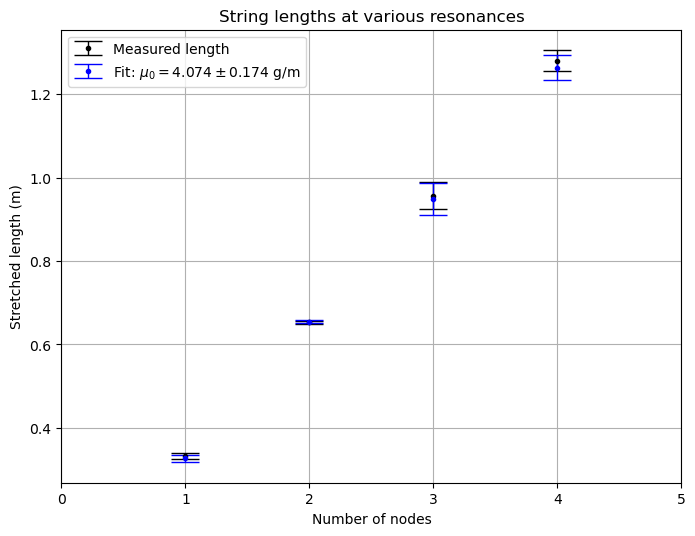

In [63]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.title("String lengths at various resonances")
plt.errorbar(
    n, L, yerr = dL,
    label="Measured length",
    color = "black", ecolor="black",
    linewidth = 0, elinewidth = 1, capsize=10, markersize = 3,
    marker = 'o'
)
plt.errorbar(
    n, model(n,mu0), yerr = model(n,mu0)*dmodel(n, mu0),
    label=f"Fit: $\mu_0 = {mu0*1000:.3f} \pm {dmu0*1000:.3f}$ g/m",
    color = "blue", ecolor="blue",
    linewidth = 0, elinewidth = 1, capsize=10, markersize = 3,
    marker = 'o'
)

plt.legend()
plt.xlabel("Number of nodes")
plt.ylabel("Stretched length (m)")
plt.xlim(0, 5)
# plt.ylim(0, 1.6)
plt.grid()
plt.savefig("3.png")
plt.show()

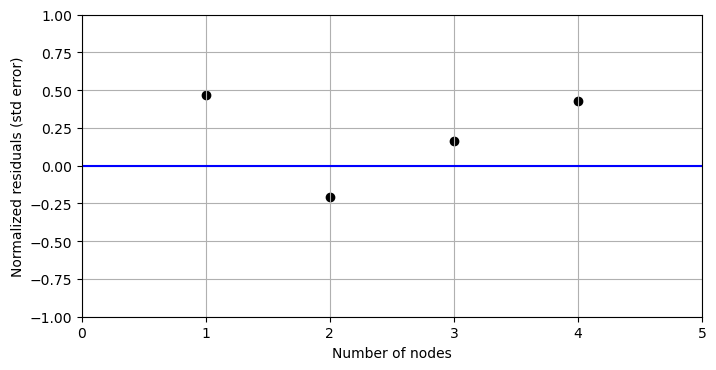

In [65]:
plt.rcParams['figure.figsize'] = [8, 4]
uncertainty = np.sqrt( (model(n,mu0)*dmodel(n, mu0))**2 + dL*dL)
plt.scatter(n, (L - model(n, mu0))/uncertainty, color="black")
# plt.legend()
plt.xlabel("Number of nodes")
plt.ylabel("Normalized residuals (std error)")
plt.xlim(0, 5)
plt.ylim(-1, 1)
plt.axhline(0, color="blue")
plt.grid()
plt.savefig("3_res.png")
plt.show()

In [67]:
dof = 1
chi2 = np.sum( ((L - model(n, mu0))/uncertainty)**2 )
chi2_reduced = chi2 / ( len(L) - dof )
chi2_reduced

0.15909830946079342